## Проанализируем активы с помощью портфельной теории Марковитца

В качесвте данных для анализа будем использовать данные по 55 активам, торгуемым на МосБирже
Входными данными для каждого актива будут исторические данные для актива с 1 января 2022 года и прогнозные данные на две недели, построенные как в https://github.com/SamoilovSD/ETF/blob/main/etf_try.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import os
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

from datetime import datetime
import datetime 

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "stix"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Times New Roman"] + plt.rcParams["font.serif"]
matplotlib.rcParams.update({'font.size': 12})

In [2]:
dateparse = lambda x: datetime.datetime.strptime(x, '%d.%m.%Y')

In [3]:
today_str = str(datetime.datetime.today())[0:10].replace('-','_')

Дата, когда делался прогноз

In [4]:
date_of_analysis = '2023_09_02'

In [5]:
start_str = 'C:/Users/Stepan/Desktop/Работа/etf_funds/data_hist/'+ date_of_analysis +'/'
save_path = 'C:/Users/Stepan/Desktop/Работа/etf_funds/result_hist/'+ date_of_analysis +'/'

In [6]:
df = pd.read_excel(save_path+'resulted_{}.xlsx'.format(date_of_analysis))
df

,bond_name,earn_high_p,earn_med_p,earn_low_p
0,AQUA,27.62,24.31,21.13
1,MRKZ,21.74,21.74,13.04
2,ARSA,16.43,12.82,8.87
3,MDMG,14.77,12.62,10.47
4,ELFV,12.53,9.97,6.14
5,MRKC,10.85,9.20,7.54
6,MRKY,19.44,8.58,8.58
7,GEMC,10.25,7.36,4.25
8,RENI,11.58,6.53,1.48
9,SELG,10.65,6.29,1.84


In [7]:
amount_of_predicted_days = 7

In [8]:
amount_of_weekdays = int(amount_of_predicted_days/7*2)

In [9]:
list_of_bonds = df.bond_name.values

### Расчет доходности, волотильности активов. А так же коэффициентов beta, Шарпа для исторических, прогнозных, полных датасетов

In [10]:
list_ETF_names = np.array([])

list_mean_history = np.array([])
list_std_history = np.array([])
list_mean_forecast = np.array([])
list_std_forecast = np.array([])
list_mean_full = np.array([])
list_std_full = np.array([])

list_coef_sharp_history = np.array([])
list_coef_sharp_forecast = np.array([])
list_coef_sharp_full = np.array([])

list_coef_trein_history = np.array([])
list_coef_trein_forecast = np.array([])
list_coef_trein_full = np.array([])

list_beta_history = np.array([])
list_beta_forecast = np.array([])
list_beta_full = np.array([])


for ETF_name in tqdm(list_of_bonds):
    df_orig = pd.read_csv('C:/Users/Stepan/Desktop/Работа/etf_funds/data_hist/{}/{}.csv'.format(date_of_analysis, ETF_name), 
                   parse_dates=['date'], date_parser=dateparse,
                   names=['date', 'price', 'price_open', 'price_max', 'price_min', 'vol', 'change_perc'], 
                   skiprows=1,  thousands = '.', decimal=",")
    df_orig = df_orig[['date', 'price']]
    new_date = pd.to_datetime(df_orig['date'],  format='%d.%m.%Y')
    df_orig['date'] = new_date

    dfn = df_orig.set_index('date').resample('D').asfreq()
    dfn['Day'] = dfn.index.strftime('%A')
    cond = dfn['Day'].isin(['Saturday', 'Sunday'])
    dfn = dfn[~cond].fillna(method='ffill').reset_index()
    df_orig = dfn.sort_values('date', ascending=True).reset_index(drop=True)
    df_orig = df_orig[['date', 'price']]
    
    df_forecast = pd.read_excel('C:/Users/Stepan/Desktop/Работа/etf_funds/result_hist/{}/{}/{}_{}.xlsx'.format(date_of_analysis,ETF_name,ETF_name,date_of_analysis), 
        thousands = '.', decimal=",")
    df_forecast = df_forecast[['date','price']]
    
    df_full = pd.concat([df_orig, df_forecast]).reset_index(drop=True)
    
    list_prices = np.array([])
    for row in df_full.itertuples():
        list_prices = np.append(list_prices, row[2])

    list_earnings = np.array([np.nan])
    for i in range(1,len(list_prices)):
        list_earnings = np.append(list_earnings, np.log(list_prices[i]/list_prices[i-1]))
    df_full['earnings'] = list_earnings
    df_full = df_full.dropna()
    
    mean_forecast = df_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.mean()*252
    std_forecast = df_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.std() * 252**(1/2)
    
    mean_history = df_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.mean()*252
    std_history = df_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.std() * 252**(1/2)
    
    mean_full = df_full.earnings.mean()*252
    std_full = df_full.earnings.std() * 252**(1/2)
    
    coef_sharp_history = mean_history/std_history
    coef_sharp_forecast = mean_forecast/std_forecast
    coef_sharp_full = mean_full/std_full
    
    df_MMVB_orig = pd.read_csv('C:/Users/Stepan/Desktop/Работа/etf_funds/data_hist/{}/ММВБ.csv'.format(date_of_analysis), 
                   parse_dates=['date'], date_parser=dateparse,
                   names=['date', 'price', 'price_open', 'price_max', 'price_min', 'vol', 'change_perc'], 
                   skiprows=1,  thousands = '.', decimal=",")
    df_MMVB_orig = df_MMVB_orig[['date', 'price']]
    new_date = pd.to_datetime(df_MMVB_orig['date'],  format='%d.%m.%Y')
    df_MMVB_orig['date'] = new_date

    dfn = df_MMVB_orig.set_index('date').resample('D').asfreq()
    dfn['Day'] = dfn.index.strftime('%A')
    cond = dfn['Day'].isin(['Saturday', 'Sunday'])
    dfn = dfn[~cond].fillna(method='ffill').reset_index()
    df_MMVB_orig = dfn.sort_values('date', ascending=True).reset_index(drop=True)
    df_MMVB_orig = df_MMVB_orig[['date', 'price']]
    df_MMVB_orig = df_MMVB_orig.query('date >= "{}"'.format(df_full.iloc[0].date-datetime.timedelta(days=1)))
    
    df_MMVB_forecast = pd.read_excel('C:/Users/Stepan/Desktop/Работа/etf_funds/result_hist/{}/ММВБ/ММВБ_{}.xlsx'.format(date_of_analysis,date_of_analysis), 
        thousands = '.', decimal=",")
    df_MMVB_forecast = df_MMVB_forecast[['date','price']]
    
    df_MMVB_full = pd.concat([df_MMVB_orig, df_MMVB_forecast]).reset_index(drop=True)
    
    list_prices = np.array([])
    for row in df_MMVB_full.itertuples():
        list_prices = np.append(list_prices, row[2])

    list_earnings = np.array([np.nan])
    for i in range(1,len(list_prices)):
        list_earnings = np.append(list_earnings, np.log(list_prices[i]/list_prices[i-1]))
        
    df_MMVB_full['earnings'] = list_earnings
    df_MMVB_full = df_MMVB_full.dropna()
    
    beta_history = LinearRegression() \
    .fit(df_MMVB_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.values.reshape((-1, 1)), 
    df_full[:-amount_of_predicted_days+amount_of_weekdays].earnings.values).coef_[0]
    
    beta_forecast = LinearRegression() \
    .fit(df_MMVB_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.values.reshape((-1, 1)), 
    df_full[-amount_of_predicted_days+amount_of_weekdays:].earnings.values).coef_[0]
    
    beta_full = LinearRegression() \
    .fit(df_MMVB_full.earnings.values.reshape((-1, 1)), 
    df_full.earnings.values).coef_[0]
    
    coef_trein_history = mean_history/beta_history
    coef_trein_forecast = mean_forecast/beta_forecast
    coef_trein_full = mean_full/beta_full
    
    list_ETF_names = np.append(list_ETF_names, ETF_name)

    list_mean_history = np.append(list_mean_history, mean_history)
    list_std_history = np.append(list_std_history, std_history)
    list_mean_forecast = np.append(list_mean_forecast, mean_forecast)
    list_std_forecast = np.append(list_std_forecast, std_forecast)
    list_mean_full = np.append(list_mean_full, mean_full)
    list_std_full = np.append(list_std_full, std_full)

    list_coef_sharp_history = np.append(list_coef_sharp_history, coef_sharp_history)
    list_coef_sharp_forecast = np.append(list_coef_sharp_forecast, coef_sharp_forecast)
    list_coef_sharp_full = np.append(list_coef_sharp_full, coef_sharp_full)

    list_coef_trein_history = np.append(list_coef_trein_history, coef_trein_history)
    list_coef_trein_forecast = np.append(list_coef_trein_forecast, coef_trein_forecast)
    list_coef_trein_full = np.append(list_coef_trein_full, coef_trein_full)

    list_beta_history = np.append(list_beta_history, beta_history)
    list_beta_forecast = np.append(list_beta_forecast, beta_forecast)
    list_beta_full = np.append(list_beta_full, beta_full)

100%|██████████████████████████████████████████████████████████████████████████████████| 55/55 [00:03<00:00, 15.63it/s]


In [11]:
df_res = pd.DataFrame({
    'bond_name':list_ETF_names,
    
    'mean_earn_history':list_mean_history,
    'std_earn_history':list_std_history,
    
    'mean_earn_forecast':list_mean_forecast,
    'std_earn_forecast':list_std_forecast,
    
    'mean_earn_full':list_mean_full,
    'std_earn_full':list_std_full,
    
    
    'coef_sharp_history':list_coef_sharp_history,
    'coef_sharp_forecast':list_coef_sharp_forecast,
    'coef_sharp_full':list_coef_sharp_full,
    
    'coef_trein_beta_history':list_coef_trein_history,
    'coef_trein_beta_forecast':list_coef_trein_forecast,
    'coef_trein_beta_full':list_coef_trein_full,
    
    'beta_history':list_beta_history,
    'beta_forecast':list_beta_forecast,
    'beta_full':list_beta_full
})
df_res = df.merge(df_res, on='bond_name', how='inner')
df_res = df_res.sort_values('earn_med_p', ascending=False)
df_res

,bond_name,earn_high_p,earn_med_p,earn_low_p,mean_earn_history,std_earn_history,mean_earn_forecast,std_earn_forecast,mean_earn_full,std_earn_full,coef_sharp_history,coef_sharp_forecast,coef_sharp_full,coef_trein_beta_history,coef_trein_beta_forecast,coef_trein_beta_full,beta_history,beta_forecast,beta_full
0,AQUA,27.62,24.31,21.13,0.750869,0.302369,10.965962,0.522239,1.037810,0.326154,2.483285,20.997968,3.181961,1.359638,1.582081,1.717844,0.552257,6.931351,0.604135
1,MRKZ,21.74,21.74,13.04,2.160203,0.659633,9.914199,0.613338,2.378012,0.661722,3.274858,16.164342,3.593674,2.146561,-1.585921,2.365061,1.006355,-6.251384,1.005476
2,ARSA,16.43,12.82,8.87,1.289925,0.414242,6.078709,0.462430,1.424442,0.417229,3.113945,13.145150,3.414055,3.085544,1.074785,3.169699,0.418054,5.655743,0.449393
3,MDMG,14.77,12.62,10.47,1.078398,0.344562,5.988842,0.258218,1.216332,0.345692,3.129763,23.192946,3.518539,1.091336,1.614963,1.203426,0.988145,3.708346,1.010725
4,ELFV,12.53,9.97,6.14,0.465739,0.310033,4.791913,0.213230,0.587260,0.310599,1.502224,22.472927,1.890737,0.526909,1.318025,0.648957,0.883907,3.635677,0.904930
5,MRKC,10.85,9.20,7.54,0.933606,0.352970,4.435382,0.070085,1.031970,0.350022,2.645001,63.285984,2.948303,0.959338,4.501487,1.050280,0.973177,0.985315,0.982567
6,MRKY,19.44,8.58,8.58,1.477505,0.434459,4.147680,0.804696,1.552510,0.445907,3.400791,5.154344,3.481689,1.660199,1.163878,1.714518,0.889957,3.563672,0.905508
7,GEMC,10.25,7.36,4.25,1.544064,0.489214,3.580897,0.296313,1.601278,0.484774,3.156212,12.084850,3.303143,1.343227,1.011290,1.378371,1.149518,3.540921,1.161718
8,RENI,11.58,6.53,1.48,1.190018,0.367825,3.187852,0.287436,1.246136,0.365753,3.235285,11.090637,3.407047,1.423811,0.975146,1.468553,0.835798,3.269101,0.848547
9,SELG,10.65,6.29,1.84,0.960706,0.332956,3.074782,0.256869,1.020090,0.331220,2.885381,11.970217,3.079801,1.153597,0.723103,1.201362,0.832792,4.252204,0.849111


In [12]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

### Продолжим рассмотрение только доходных активов

In [13]:
df_qir = df_res.query('(mean_earn_history > 0) & (std_earn_history > 0)')

График волотильности-доходности, цветовой палитрой показана прогнозируемая доходность на ближайшие 2 недели выполненная по методике https://github.com/SamoilovSD/ETF/blob/main/etf_try.ipynb

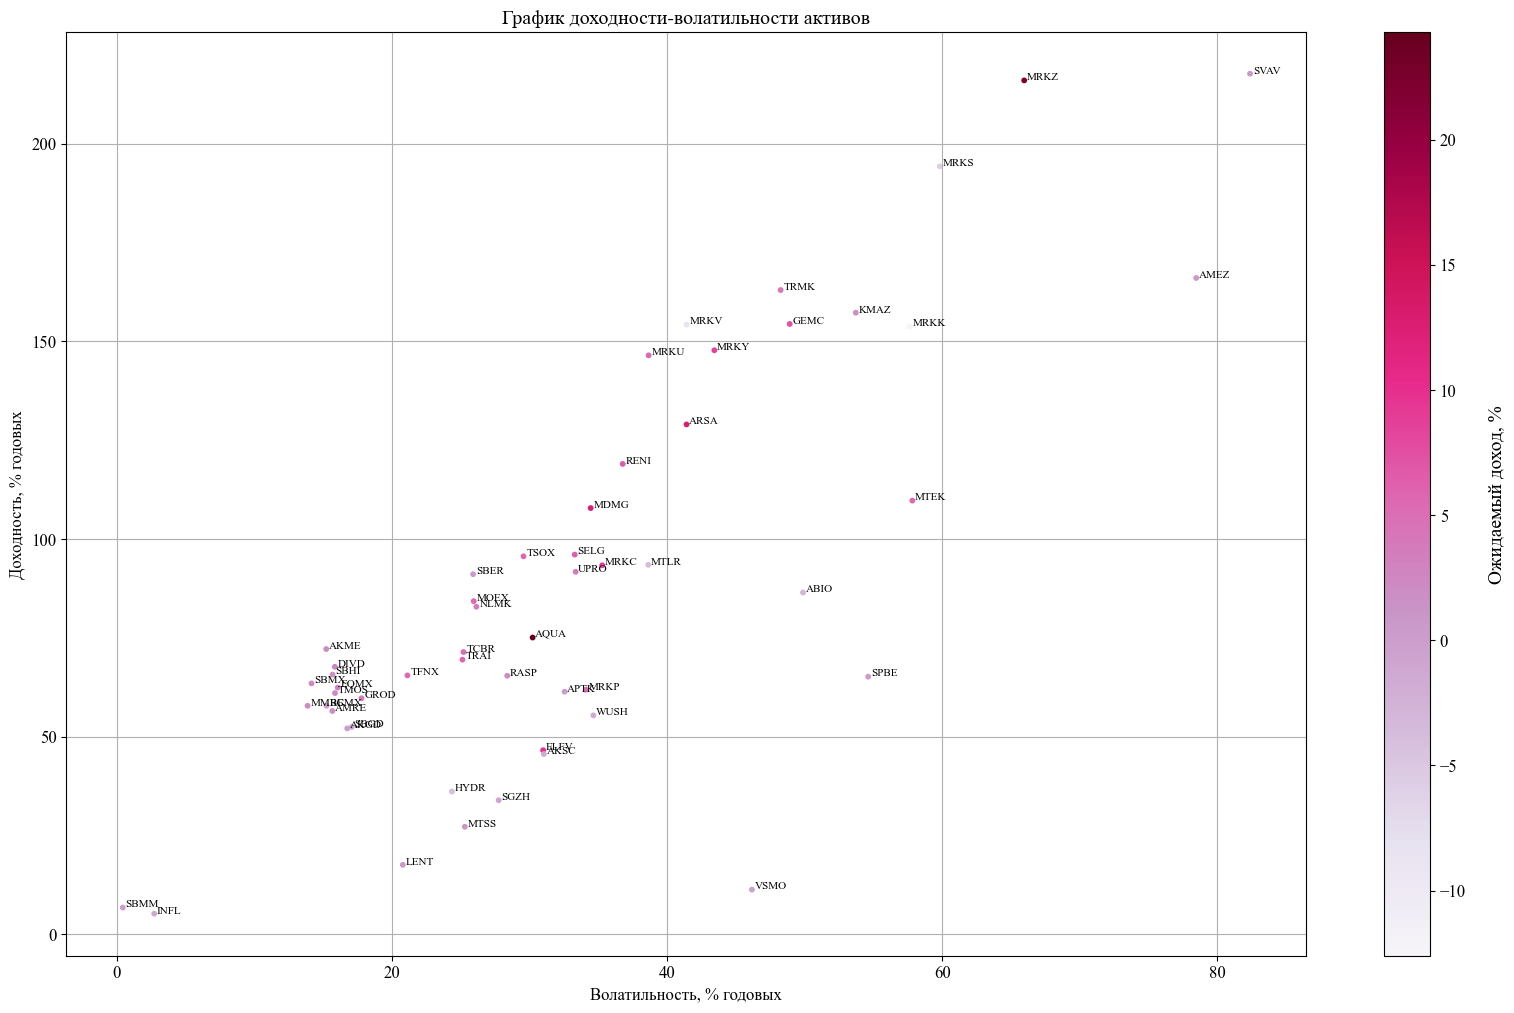

In [14]:
fig, ax = plt.subplots(figsize=(20,12))
ax.scatter(df_qir.std_earn_history*100, df_qir.mean_earn_history*100, c=df_qir.earn_med_p, cmap='PuRd', s=10)
ax.set_ylabel('Доходность, % годовых')
ax.set_xlabel('Волатильность, % годовых')
ax.set_title('График доходности-волатильности активов')
for idx, row in df_qir.iterrows():
    ax.annotate(row['bond_name'], (row['std_earn_history']*100+0.2, row['mean_earn_history']*100+0.2), fontsize=8) #row['bond_name']

    
    
norm = plt.Normalize(np.min(df_qir.earn_med_p), np.max(df_qir.earn_med_p))
smap = plt.cm.ScalarMappable(cmap='PuRd', norm=norm)
cbar = fig.colorbar(smap, ax=ax)
cbar.ax.tick_params(labelsize=12)
cbar.ax.set_ylabel('Ожидаемый доход, %', rotation=90, labelpad = 15, fontdict = {"size":14})
ax.grid()
plt.show()
fig.savefig('graph.png', dpi=1500)

Итоговый датафрейм

In [15]:
df_res[['bond_name', 'earn_high_p', 'earn_med_p', 'earn_low_p', 'coef_sharp_history', 'coef_sharp_full']].sort_values('earn_med_p', ascending=False)

,bond_name,earn_high_p,earn_med_p,earn_low_p,coef_sharp_history,coef_sharp_full
0,AQUA,27.62,24.31,21.13,2.483285,3.181961
1,MRKZ,21.74,21.74,13.04,3.274858,3.593674
2,ARSA,16.43,12.82,8.87,3.113945,3.414055
3,MDMG,14.77,12.62,10.47,3.129763,3.518539
4,ELFV,12.53,9.97,6.14,1.502224,1.890737
5,MRKC,10.85,9.20,7.54,2.645001,2.948303
6,MRKY,19.44,8.58,8.58,3.400791,3.481689
7,GEMC,10.25,7.36,4.25,3.156212,3.303143
8,RENI,11.58,6.53,1.48,3.235285,3.407047
9,SELG,10.65,6.29,1.84,2.885381,3.079801


Выборка активов, у которых параметры доходности, волатильности, коэф. Шарпа отличаются не более, чем на 10%.

Отсортированы по средней ожидаемой доходности

In [16]:
df_res.query('(coef_sharp_history >= coef_sharp_full*0.9) & (mean_earn_history >= mean_earn_full*0.9) & (std_earn_history >= std_earn_full*0.9)')

,bond_name,earn_high_p,earn_med_p,earn_low_p,mean_earn_history,std_earn_history,mean_earn_forecast,std_earn_forecast,mean_earn_full,std_earn_full,coef_sharp_history,coef_sharp_forecast,coef_sharp_full,coef_trein_beta_history,coef_trein_beta_forecast,coef_trein_beta_full,beta_history,beta_forecast,beta_full
1,MRKZ,21.74,21.74,13.04,2.160203,0.659633,9.914199,0.613338,2.378012,0.661722,3.274858,16.164342,3.593674,2.146561,-1.585921,2.365061,1.006355,-6.251384,1.005476
2,ARSA,16.43,12.82,8.87,1.289925,0.414242,6.078709,0.462430,1.424442,0.417229,3.113945,13.145150,3.414055,3.085544,1.074785,3.169699,0.418054,5.655743,0.449393
6,MRKY,19.44,8.58,8.58,1.477505,0.434459,4.147680,0.804696,1.552510,0.445907,3.400791,5.154344,3.481689,1.660199,1.163878,1.714518,0.889957,3.563672,0.905508
7,GEMC,10.25,7.36,4.25,1.544064,0.489214,3.580897,0.296313,1.601278,0.484774,3.156212,12.084850,3.303143,1.343227,1.011290,1.378371,1.149518,3.540921,1.161718
8,RENI,11.58,6.53,1.48,1.190018,0.367825,3.187852,0.287436,1.246136,0.365753,3.235285,11.090637,3.407047,1.423811,0.975146,1.468553,0.835798,3.269101,0.848547
9,SELG,10.65,6.29,1.84,0.960706,0.332956,3.074782,0.256869,1.020090,0.331220,2.885381,11.970217,3.079801,1.153597,0.723103,1.201362,0.832792,4.252204,0.849111
10,MRKP,8.49,5.85,3.20,0.618837,0.340952,2.864481,0.210058,0.681917,0.338395,1.815026,13.636634,2.015151,0.773091,1.948301,0.843603,0.800471,1.470246,0.808339
11,MOEX,7.62,5.73,3.83,0.842840,0.259571,2.809592,0.073657,0.898086,0.256940,3.247045,38.144519,3.495317,0.954590,3.228273,1.011848,0.882934,0.870308,0.887570
12,TRAI,11.57,5.71,-0.14,0.694988,0.251378,2.800720,0.121171,0.754137,0.249441,2.764713,23.113839,3.023313,2.666613,2.376935,2.795380,0.260626,1.178291,0.269780
13,TSOX,8.54,5.69,2.95,0.956323,0.295761,2.789236,0.069622,1.007810,0.292368,3.233431,40.062470,3.447055,2.998786,4.177778,3.098527,0.318903,0.667636,0.325255
